# A Convolutional Neural Network Model for Credit Card Fraud Detection

## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torchvision import transforms

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

## Setting up the GPU

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


## Loading the Dataset

In [3]:
# modify the root_dir to the path of the dataset
root_dir =  '/kaggle/input/creditcardfraud/creditcard.csv'
data = pd.read_csv(root_dir)

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Data Distribution

In [7]:
amount = data['Amount'].value_counts()
print(amount)

Amount
1.00       13688
1.98        6044
0.89        4872
9.99        4747
15.00       3280
           ...  
62.09          1
552.05         1
1467.75        1
196.68         1
95.63          1
Name: count, Length: 32767, dtype: int64


In [8]:
label = data['Class'].value_counts()
print(label)

Class
0    284315
1       492
Name: count, dtype: int64


In [9]:
def data_distribution(data):
    classes_counts = data.groupby('Class').size().reset_index(name='count')
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classes_counts)))
    plt.bar(classes_counts['Class'], classes_counts['count'], color=colors)
    for i, v in enumerate(classes_counts['count']):
        plt.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=8)
    classes_names = data['Class'].unique() 
    plt.xticks(classes_counts['Class'], classes_names, size=10, rotation=45)
    plt.xlabel('Class', size=12)
    plt.ylabel('Frequency', size=12)
    plt.title('Class Distribution of Dataset', size=13)
    plt.show()

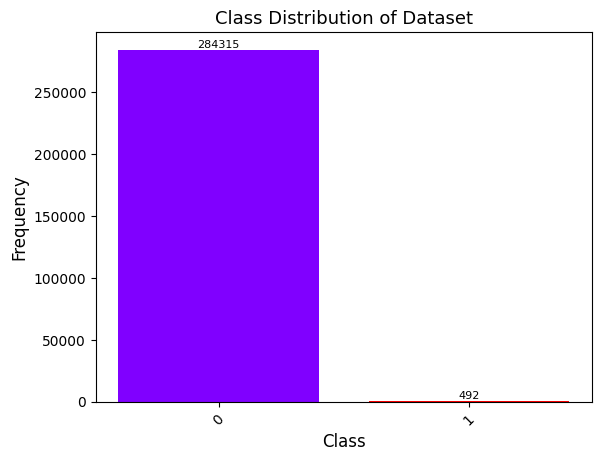

In [10]:
data_distribution(data)

### Processing Data

### Removing duplicate samples

In [11]:
dup =data[data.duplicated()]
print(dup.shape)

(1081, 31)


In [12]:
data.drop_duplicates(inplace=True)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283726 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float64
 1   V1      283726 non-null  float64
 2   V2      283726 non-null  float64
 3   V3      283726 non-null  float64
 4   V4      283726 non-null  float64
 5   V5      283726 non-null  float64
 6   V6      283726 non-null  float64
 7   V7      283726 non-null  float64
 8   V8      283726 non-null  float64
 9   V9      283726 non-null  float64
 10  V10     283726 non-null  float64
 11  V11     283726 non-null  float64
 12  V12     283726 non-null  float64
 13  V13     283726 non-null  float64
 14  V14     283726 non-null  float64
 15  V15     283726 non-null  float64
 16  V16     283726 non-null  float64
 17  V17     283726 non-null  float64
 18  V18     283726 non-null  float64
 19  V19     283726 non-null  float64
 20  V20     283726 non-null  float64
 21  V21     283726 

### Split the data into train and test sets

In [14]:
data.reset_index(drop=True, inplace=True)
X = data.drop('Class', axis=1)
y = data['Class']

In [15]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
y_train1 = np.array(y_train1).reshape(-1, 1)
encoder = OneHotEncoder()
y_train_encoded1 = encoder.fit_transform(y_train1).toarray()

In [17]:
print('Number of train samples =', len(X_train1))
print('Number of test samples =', len(X_test1))    

Number of train samples = 226980
Number of test samples = 56746


### Standardize the features

In [18]:
scaler = StandardScaler()
X_train1 = scaler.fit_transform(X_train1)
X_test1 = scaler.transform(X_test1)

## Model Implementation

In [19]:
class CONVNETS:
    def __init__(self, input_shape, num_classes=2):
        self.model = Sequential([
            Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(input_shape, 1)),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(0.2),
            
            Conv1D(filters=64, kernel_size=2, activation='relu'),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(0.5),
            
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])
        
        self.model.compile(
            loss='binary_crossentropy', 
            optimizer=Adam(learning_rate=0.0001), 
            metrics=['accuracy'])

    def fit(self, X, y, epoch=46, batch=128):
        return self.model.fit(X, y, validation_split=0.25, epochs=epoch)

    def predict(self, X):
        return self.model.predict(X)
    
    def evaluate(self, X, y):
        return self.model.evaluate(X, y)

#### Plot accuracy and loss

In [20]:
def plot_loss_and_accuracy(train_loss, val_loss, train_accuracy, val_accuracy):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    axes[0].plot(train_loss, label="Train loss")
    axes[0].plot(val_loss, label="Validation loss")
    axes[0].set_ylabel("Loss", fontsize=12)
    axes[0].set_xlabel("Epoch", fontsize=12)
    axes[0].legend(prop={'size': 10})

    axes[1].plot(train_accuracy, label="Train Accuracy")
    axes[1].plot(val_accuracy, label="Validation Accuracy")
    axes[1].set_ylabel("Score", fontsize=12)
    axes[1].set_xlabel("Epoch", fontsize=12)
    axes[1].legend(prop={'size': 10})

    plt.tight_layout()
    plt.show()

### Training

In [21]:
model1 = CONVNETS(X_train1.shape[1])
history = model1.fit(X_train1, y_train_encoded1)

Epoch 1/46
5320/5320 [==============================] - 32s 6ms/step - loss: 0.0295 - accuracy: 0.9962 - val_loss: 0.0149 - val_accuracy: 0.9989
Epoch 2/46
5320/5320 [==============================] - 29s 5ms/step - loss: 0.0077 - accuracy: 0.9988 - val_loss: 0.0085 - val_accuracy: 0.9991
Epoch 3/46
5320/5320 [==============================] - 29s 5ms/step - loss: 0.0062 - accuracy: 0.9991 - val_loss: 0.0061 - val_accuracy: 0.9993
Epoch 4/46
5320/5320 [==============================] - 30s 6ms/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 0.0056 - val_accuracy: 0.9993
Epoch 5/46
5320/5320 [==============================] - 29s 5ms/step - loss: 0.0048 - accuracy: 0.9992 - val_loss: 0.0045 - val_accuracy: 0.9993
Epoch 6/46
5320/5320 [==============================] - 32s 6ms/step - loss: 0.0046 - accuracy: 0.9992 - val_loss: 0.0047 - val_accuracy: 0.9993
Epoch 7/46
5320/5320 [==============================] - 30s 6ms/step - loss: 0.0044 - accuracy: 0.9993 - val_loss: 0.0049 - val_ac

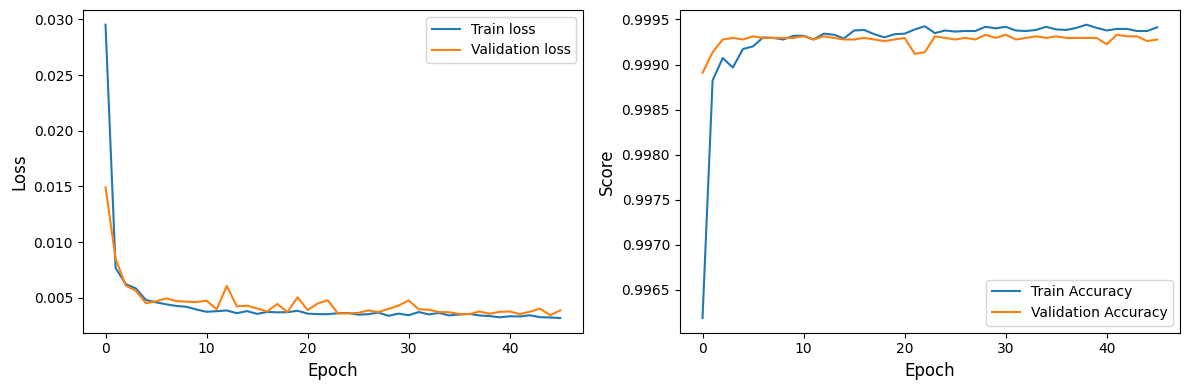

In [22]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
plot_loss_and_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

### F1, Precision, and Recall Metrics

In [23]:
probabilities = model1.predict(X_test1)
binary_predictions = np.argmax(probabilities, axis=1)
print("Classification Report:")
print(classification_report(y_test1, binary_predictions))

1774/1774 [==============================] - 3s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.88      0.66      0.75        90

    accuracy                           1.00     56746
   macro avg       0.94      0.83      0.88     56746
weighted avg       1.00      1.00      1.00     56746



In [24]:
print(f"Accuracy: {accuracy_score(y_test1, binary_predictions):.4f}")
print(f"Overall Precision: {precision_score(y_test1, binary_predictions):.4f}")
print(f"Recall: {recall_score(y_test1, binary_predictions):.4f}")
print(f"F1-score: {f1_score(y_test1, binary_predictions):.4f}")

Accuracy: 0.9993
Overall Precision: 0.8806
Recall: 0.6556
F1-score: 0.7516


### Confucsion Matrix

In [25]:
confusion_m = confusion_matrix(y_test1, binary_predictions)
print(confusion_m)

[[56648     8]
 [   31    59]]


<Axes: >

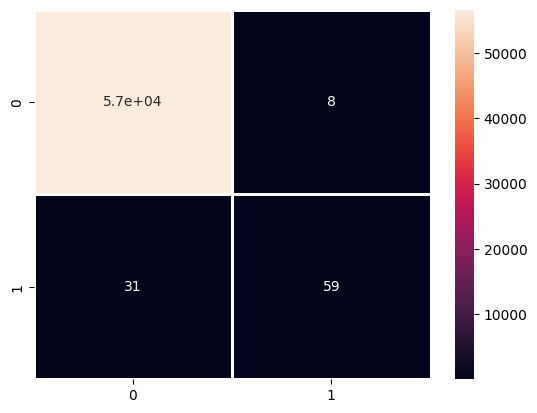

In [26]:
sns.heatmap(confusion_m, annot=True, linecolor='white', linewidths=1)

### Adaptive Synthetic Sampling

ADASYN (Adaptive Synthetic) is an algorithm that generates synthetic data, and its greatest advantages are not copying the same minority data, and generating more data for “harder to learn” examples

In [27]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

class ADASYN:
    def __init__(self, n_neighbors=5, ratio=1, random_seed=None):
        self.n_neighbors = n_neighbors
        self.ratio = ratio
        self.random_seed = random_seed
        self.synthetic_samples = []

    def fit_resample(self, X, y):
        np.random.seed(self.random_seed)
        
        # Separate minority and majority class samples
        minority_samples = X[y == 1]
        majority_samples = X[y == 0]
        len_minority_samples = len(minority_samples)
        len_majority_samples  = len(majority_samples)
        
        # Calculate imbalance ratio
        imbalance_ratio = len_majority_samples / len_minority_samples
        
        # Calculate number of synthetic samples to generate
        num_synthetic_samples = (len_majority_samples - len_minority_samples) * self.ratio
       
        # Find k-nearest neighbors for each minority sample        
        neighbors = KNeighborsClassifier()
        neighbors.fit(X, y)

        # For each minority sample, compute the ratio of samples in the K-nearest neighbors that belong to the majority class
        ratios = []
        Minority_per_samples = []
        for sample in minority_samples:
            xi = sample.reshape(1, -1)
            indices = neighbors.kneighbors(xi, n_neighbors=self.n_neighbors, return_distance=False)[0]
            ratio = len([i for i in indices if y[i] != 1]) / self.n_neighbors
            ratios.append(ratio)
            
            minority_neighbors = []
            for i in indices:
                if y[i] == 1:
                    minority_neighbors.append(i)
            Minority_per_samples.append(minority_neighbors)
        
        ratios = np.array(ratios)
        ratios = ratios / np.sum(ratios)

        for i, sample in enumerate(minority_samples):
            # Determine the number of synthetic samples to generate for this sample
            num = int(ratios[i] * num_synthetic_samples)

            for _ in range(num):
                neighbor = X[np.random.choice(Minority_per_samples[i])]
                diff = neighbor - sample
                synthetic_sample = sample + np.random.random() * diff
                self.synthetic_samples.append(synthetic_sample)
                
        
        resampled_X = np.vstack((X, np.array(self.synthetic_samples)))
        resampled_y = np.hstack((y, np.ones(len(self.synthetic_samples))))
        shuffle_indices = np.random.permutation(len(resampled_X))
        resampled_X = resampled_X[shuffle_indices]
        resampled_y = resampled_y[shuffle_indices]
        return resampled_X, resampled_y

In [28]:
X2 = X.values
y2 = y.values

In [29]:
adasyn = ADASYN(n_neighbors=5, ratio=1)
X2, y2 = adasyn.fit_resample(X2, y2)

### Split the data into train and test sets

In [30]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
print('Number of train samples =', len(X_train2))
print('Number of test samples =', len(X_test2)) 
y_train2 = np.array(y_train2).reshape(-1, 1)
encoder = OneHotEncoder()
y_train_encoded2 = encoder.fit_transform(y_train2).toarray()

Number of train samples = 452873
Number of test samples = 113219


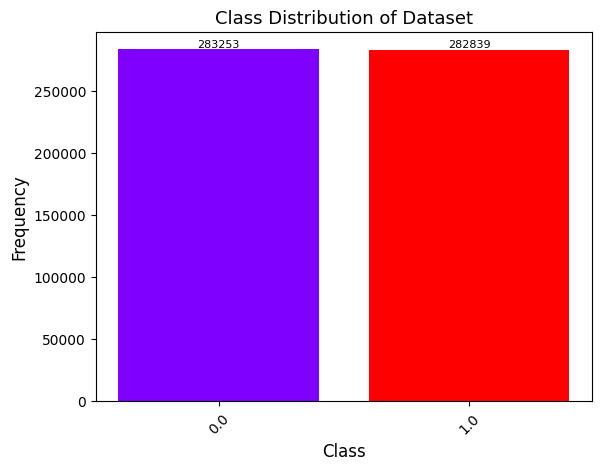

In [31]:
df_y_train2 = pd.DataFrame(y2, columns=['Class'])
data_distribution(df_y_train2)

### Standardize the features

In [32]:
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

### Training on Resampled Dataset

In [33]:
model2 = CONVNETS(X_train2.shape[1])
resampled_history = model2.fit(X_train2, y_train_encoded2)

Epoch 1/46
10615/10615 [==============================] - 62s 6ms/step - loss: 0.2024 - accuracy: 0.9237 - val_loss: 0.1162 - val_accuracy: 0.9532
Epoch 2/46
10615/10615 [==============================] - 62s 6ms/step - loss: 0.1345 - accuracy: 0.9477 - val_loss: 0.0759 - val_accuracy: 0.9783
Epoch 3/46
10615/10615 [==============================] - 59s 6ms/step - loss: 0.1061 - accuracy: 0.9589 - val_loss: 0.0537 - val_accuracy: 0.9869
Epoch 4/46
10615/10615 [==============================] - 59s 6ms/step - loss: 0.0880 - accuracy: 0.9660 - val_loss: 0.0424 - val_accuracy: 0.9885
Epoch 5/46
10615/10615 [==============================] - 59s 6ms/step - loss: 0.0765 - accuracy: 0.9710 - val_loss: 0.0368 - val_accuracy: 0.9895
Epoch 6/46
10615/10615 [==============================] - 60s 6ms/step - loss: 0.0679 - accuracy: 0.9744 - val_loss: 0.0344 - val_accuracy: 0.9899
Epoch 7/46
10615/10615 [==============================] - 65s 6ms/step - loss: 0.0616 - accuracy: 0.9767 - val_loss: 0

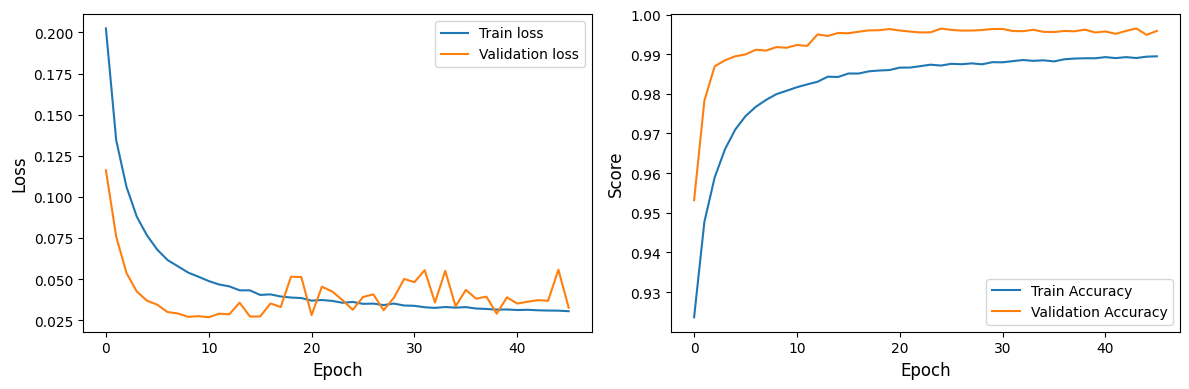

In [34]:
train_loss = resampled_history.history['loss']
train_accuracy = resampled_history.history['accuracy']
val_loss = resampled_history.history['val_loss']
val_accuracy = resampled_history.history['val_accuracy']
plot_loss_and_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

### F1, Precision, and Recall Metrics

In [35]:
probabilities = model2.predict(X_test2)
binary_predictions_resampled = np.argmax(probabilities, axis=1)
print("Classification Report:")
print(classification_report(y_test2, binary_predictions_resampled))

3539/3539 [==============================] - 7s 2ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     56303
         1.0       0.99      1.00      1.00     56916

    accuracy                           1.00    113219
   macro avg       1.00      1.00      1.00    113219
weighted avg       1.00      1.00      1.00    113219



In [36]:
print(f"Accuracy: {accuracy_score(y_test2, binary_predictions_resampled):.4f}")
print(f"Overall Precision: {precision_score(y_test2, binary_predictions_resampled):.4f}")
print(f"Recall: {recall_score(y_test2, binary_predictions_resampled):.4f}")
print(f"F1-score: {f1_score(y_test2, binary_predictions_resampled):.4f}")

Accuracy: 0.9958
Overall Precision: 0.9916
Recall: 1.0000
F1-score: 0.9958


### Confucsion Matrix

In [37]:
confusion_m = confusion_matrix(y_test2, binary_predictions_resampled)
print(confusion_m)

[[55822   481]
 [    0 56916]]


<Axes: >

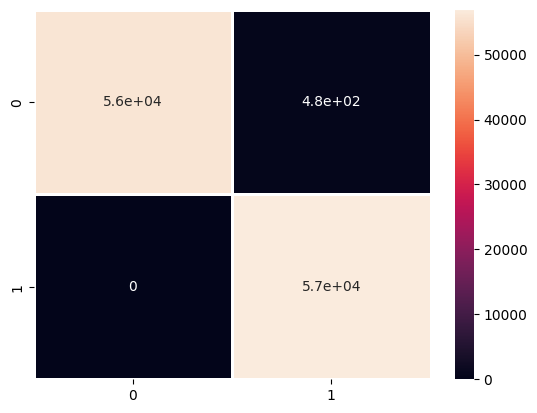

In [38]:
sns.heatmap(confusion_m, annot=True, linecolor='white', linewidths=1)